In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box

In [3]:
import os

directory = "df2csv"
dfs = {}

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        
        parts = filename[:-4].split('_') 
        species = '_'.join(parts[:-1])  
        year = parts[-1]  
        
        if species not in dfs:
            dfs[species] = {}
        
        dfs[species][year] = df
dfs.pop('cornuta', None)


{'2003':             lat      long
 0     51.880355  5.786593
 1     51.835415  4.988211
 2     51.384225  6.141377
 3     49.009998  9.000000
 4     48.938000  8.837000
 ...         ...       ...
 2151  48.938000  8.837000
 2152  49.000000  8.300000
 2153  49.000000  8.300000
 2154  49.010000  9.000000
 2155  50.623270  5.656240
 
 [2156 rows x 2 columns],
 '2023':              lat       long
 0      51.024975  13.708278
 1      51.024975  13.708278
 2      51.024975  13.791615
 3      51.024975  13.791615
 4      51.024975  13.791615
 ...          ...        ...
 30101  49.517217   8.201899
 30102  49.463610   8.290625
 30103  49.463143   8.290715
 30104  49.463592   8.290598
 30105  49.315503   8.391229
 
 [30106 rows x 2 columns],
 'all':              lat       long
 0      51.024975  13.708278
 1      51.024975  13.708278
 2      51.024975  13.791615
 3      51.024975  13.791615
 4      51.024975  13.791615
 ...          ...        ...
 32411  49.517217   8.201899
 32412  49.46361

In [4]:
for species, years_dict in dfs.items():
    for year, gdf in years_dict.items():
        gdf = gdf[gdf['long'] < -60]
        dfs[species][year] = gdf

In [5]:
dfs['lignaria']['2023'] = dfs['lignaria']['2023'][dfs['lignaria']['2023']['long']<-60]

In [6]:

def create_geodf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
    gdf.crs = "EPSG:32610"
    return gdf

def create_grid(bounds, grid_size):
    xmin, ymin, xmax, ymax = bounds
    rows = int((ymax-ymin) / grid_size)
    cols = int((xmax-xmin) / grid_size)
    grids = []
    for i in range(cols):
        for j in range(rows):
            grids.append(box(xmin+i*grid_size, ymin+j*grid_size, xmin+(i+1)*grid_size, ymin+(j+1)*grid_size))
    gdf_grid = gpd.GeoDataFrame(geometry=grids)
    gdf_grid.crs = "EPSG:32610"
    return gdf_grid

def count_occupied_grids(gdf_points, gdf_grid):
    point_in_grid = gpd.sjoin(gdf_points, gdf_grid, how="inner", predicate='intersects')
    unique_grids = point_in_grid['index_right'].nunique()
    return unique_grids

def count_new_occupied_grids(gdf_2003, gdf_2023, gdf_grid):

    joined_2003 = gpd.sjoin(gdf_grid, gdf_2003, how="inner", predicate='contains')
    joined_2023 = gpd.sjoin(gdf_grid, gdf_2023, how="inner", predicate='contains')

    # Find unique grid IDs occupied at each time point
    occupied_2003 = set(joined_2003.index)
    occupied_2023 = set(joined_2023.index)

    # Identify new grids in 2023 that were not occupied in 2003
    new_occupied_grids = occupied_2023 - occupied_2003

    # Count of newly occupied grids
    new_occupied_count = len(new_occupied_grids)

    return new_occupied_count


def get_new_occupied_grids(gdf_2003, gdf_2023, gdf_grid):

    joined_2003 = gpd.sjoin(gdf_grid, gdf_2003, how="inner", predicate='contains')
    joined_2023 = gpd.sjoin(gdf_grid, gdf_2023, how="inner", predicate='contains')

    # Find unique grid IDs occupied at each time point
    occupied_2003 = set(joined_2003.index)
    occupied_2023 = set(joined_2023.index)

    # Identify new grids in 2023 that were not occupied in 2003
    new_occupied_grids = occupied_2023 - occupied_2003

    return new_occupied_grids

def calculate_percent_change_for_species(species_data, grid_size):
   
    percent_change = None
    
    # Check if both years are in the data
    if '2003' in species_data and '2023' in species_data:
        # Calculate the number of occupied grid cells for each year
        occupied_2003 = count_occupied_grids(create_geodf(species_data['2003']), grid_size)
        occupied_2023 = count_occupied_grids(create_geodf(species_data['2023']), grid_size)
        
        # Calculate percent change
        if occupied_2003 > 0:  # Prevent division by zero
            percent_change = ((occupied_2023 - occupied_2003) / occupied_2003) * 100
        else:
            percent_change = "No data in 2003"  # Or another appropriate message/error handling
    
    return percent_change


In [7]:
lig_2003 = create_geodf(dfs['lignaria']['2003'])
lig_2023 = create_geodf(dfs['lignaria']['2023'])
lig_all = pd.concat([lig_2003, lig_2023], ignore_index=True)

tau_2003 = create_geodf(dfs['taurus']['2003'])
tau_2023 = create_geodf(dfs['taurus']['2023'])
tau_all = pd.concat([tau_2003, tau_2023], ignore_index=True)

cfs_2003 = create_geodf(dfs['cornifrons']['2003'])
cfs_2023 = create_geodf(dfs['cornifrons']['2023'])
cfs_all = pd.concat([cfs_2003, cfs_2023], ignore_index=True)



In [8]:
bounds = [-126, 23, -64, 60]
grid_size = 2

xmin, ymin, xmax, ymax = bounds
rows = int((ymax-ymin) / grid_size)
cols = int((xmax-xmin) / grid_size)
grids = []
for i in range(cols):
    for j in range(rows):
        grids.append(box(xmin+i*grid_size, ymin+j*grid_size, xmin+(i+1)*grid_size, ymin+(j+1)*grid_size))
gdf_grid = gpd.GeoDataFrame(geometry=grids)
gdf_grid.crs = "EPSG:32610"

In [9]:
bounds = [-126, 23, -64, 60]
grid_sizes = np.linspace(0.1,2, num=200, endpoint=True)

result_dict = {}

for species, years_dict in dfs.items():
    gdf_dict = {}
    result_dict[species] = {}
    for year, gdf in years_dict.items():
        gdf = create_geodf(gdf)
        gdf_dict[year] = gdf
    for grid_size in grid_sizes:
        gdf_grid = create_grid(bounds, grid_size)
        old_grid_squares = count_occupied_grids(gdf_dict['2003'], gdf_grid)
        new_grid_squares = count_new_occupied_grids(gdf_dict['2003'], gdf_dict['all'], gdf_grid)
        result_dict[species][grid_size] = new_grid_squares/old_grid_squares




In [19]:
bounds = [-126, 23, -64, 60]
grid_sizes = [1.5]

barplot_dict = {}

for species, years_dict in dfs.items():
    gdf_dict = {}
    barplot_dict[species] = {}
    for year, gdf in years_dict.items():
        gdf = create_geodf(gdf)
        gdf_dict[year] = gdf
    for grid_size in grid_sizes:
        gdf_grid = create_grid(bounds, grid_size)
        old_grid_squares = count_occupied_grids(gdf_dict['2003'], gdf_grid)
        new_grid_squares = count_new_occupied_grids(gdf_dict['2003'], gdf_dict['all'], gdf_grid)
        barplot_dict[species]['old'] = old_grid_squares
        barplot_dict[species]['new'] = new_grid_squares


lignaria, 0.32547169811320753%
taurus, 22.666666666666668%
cornifrons, 9.142857142857142%


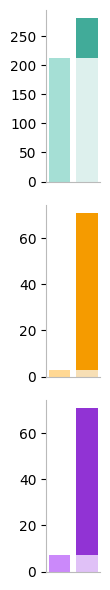

In [73]:
bar_colors = [['#a5dfd5', '#ddf0ed', '#41ab99'], ['#ffd894', '#f7dfb5', '#f59b00'], ['#cb89fa', '#e0c1f7', '#9133d4']]

fig, axs = plt.subplots(len(barplot_dict), 1, figsize=(1.2, 6))

for i, (species, counts) in enumerate(barplot_dict.items()):
    i_col = 0

    axs[i].bar('1', counts['old'], label='Old', color=bar_colors[i][i_col])
    i_col+=1
    axs[i].bar('2', counts['old'], color=bar_colors[i][i_col])
    i_col+=1
    axs[i].bar('2', counts['new'], bottom=counts['old'], color=bar_colors[i][i_col])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    # axs[i].set_ylim(0, 300)
    # axs[i].set_title(species)
    # axs[i].set_ylabel('Count')
    print(f'{species}, {counts['new']/counts['old']}%')
    for spine in axs[i].spines.values():
        spine.set_edgecolor('#bababa')
    axs[i].spines[['right', 'top']].set_visible(False)

plt.tight_layout()

plt.savefig('../figures/svg/percent_change_barplot.svg', format='svg')

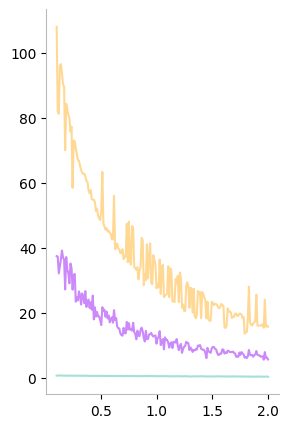

In [ ]:
colors = ['#a5dfd5', '#ffd894', '#cb89fa']
fig, ax = plt.subplots(figsize=(3, 5))



i=0

for species, values_dict in result_dict.items():
    times = sorted(values_dict.keys())
    values = [values_dict[time] for time in times]
    ax.plot(times, values, label=species, c=colors[i])
    i+=1
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
ax.spines[['right', 'top']].set_visible(False)
# ax.set_xlabel('grid_size') 
# ax.set_ylabel('percent_change') 
# ax.legend()

plt.savefig('../figures/dist/delta_plot_2.svg', format='svg', bbox_inches='tight', pad_inches=0)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

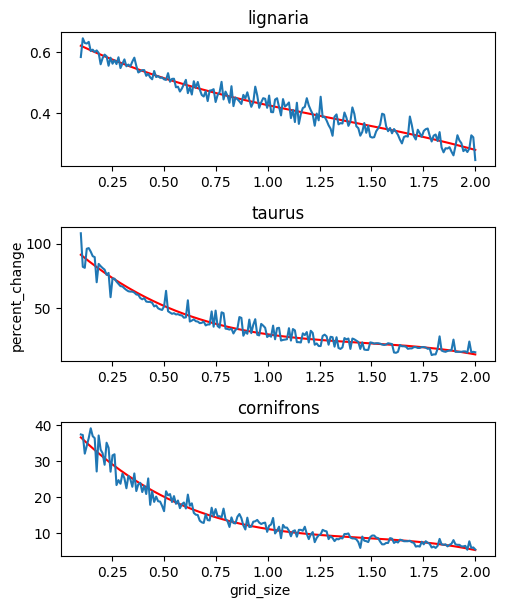

In [ ]:
num_species = len(result_dict)

fig, axs = plt.subplots(num_species, 1, figsize=(5, 2 * num_species))

degree = 3
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

for ax, (species, values_dict) in zip(axs, result_dict.items()):
    points = sorted(values_dict.keys())
    values = [values_dict[time] for time in points]
    X = np.array(points)

    # y = np.array(values)

    poly_model.fit(X.reshape(-1, 1), values)
    y_pred = poly_model.predict(X.reshape(-1, 1))


    ax.plot(X, y_pred, color='red', label='Fitted model')


    ax.plot(points, values)
    ax.set_title(species) 

fig.text(0.5, 0, 'grid_size', ha='center')
fig.text(0, 0.5, 'percent_change', va='center', rotation='vertical')

plt.tight_layout()

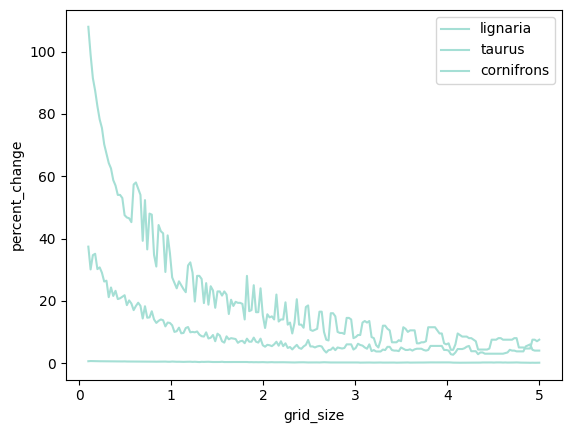

In [ ]:
bounds = [-126, 23, -64, 60]
grid_sizes = np.linspace(0.1,5, num=200, endpoint=True)

result_dict = {}

for species, years_dict in dfs.items():
    gdf_dict = {}
    result_dict[species] = {}
    for year, gdf in years_dict.items():
        gdf = create_geodf(gdf)
        gdf_dict[year] = gdf
    for grid_size in grid_sizes:
        gdf_grid = create_grid(bounds, grid_size)
        old_grid_squares = count_occupied_grids(gdf_dict['2003'], gdf_grid)
        new_grid_squares = count_new_occupied_grids(gdf_dict['2003'], gdf_dict['all'], gdf_grid)
        result_dict[species][grid_size] = new_grid_squares/old_grid_squares




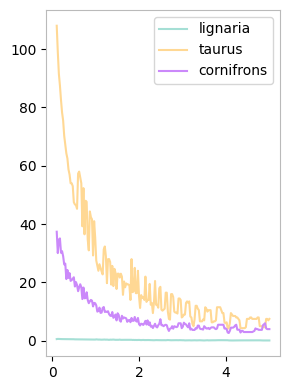

In [ ]:
colors = ['#a5dfd5', '#ffd894', '#cb89fa']

fig, ax = plt.subplots(figsize=(3, 4))

i = 0
for species, values_dict in result_dict.items():
    times = sorted(values_dict.keys())
    values = [values_dict[time] for time in times]
    ax.plot(times, values, label=species, c=colors[i])
    i += 1

# ax.set_xlabel('grid_size') 
# ax.set_ylabel('percent_change') 
    
ax.legend()
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
# plt.savefig('../figures/dist/delta_plot.svg', format='svg', bbox_inches='tight', pad_inches=0)

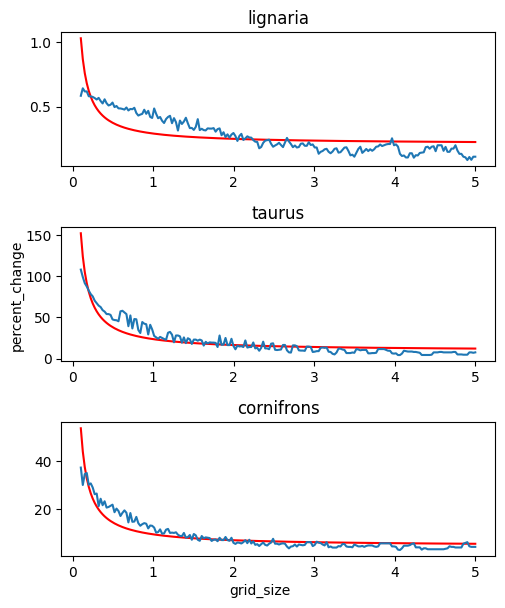

In [ ]:
def reciprocal_model(x, a, b):
    return a + b / x
fig, axs = plt.subplots(num_species, 1, figsize=(5, 2 * num_species))

from scipy.optimize import curve_fit


for ax, (species, values_dict) in zip(axs, result_dict.items()):
    points = sorted(values_dict.keys())
    values = [values_dict[time] for time in points]

    x_data = np.array(points) 
    y_data = np.array(values)  
    params, covariance = curve_fit(reciprocal_model, x_data, y_data)
    y_pred = reciprocal_model(x_data, *params)

    a_estimated, b_estimated = params 

    ax.plot(x_data, y_pred, color='red', label='Fitted model')


    ax.plot(points, values)
    ax.set_title(species) 

fig.text(0.5, 0, 'grid_size', ha='center')
fig.text(0, 0.5, 'percent_change', va='center', rotation='vertical')

plt.tight_layout()





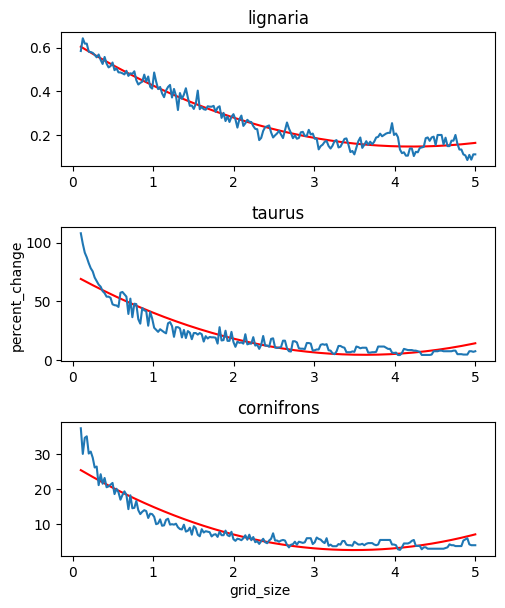

In [ ]:
num_species = len(result_dict)

fig, axs = plt.subplots(num_species, 1, figsize=(5, 2 * num_species))

degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

for ax, (species, values_dict) in zip(axs, result_dict.items()):
    points = sorted(values_dict.keys())
    values = [values_dict[time] for time in points]
    X = np.array(points)

    # y = np.array(values)

    poly_model.fit(X.reshape(-1, 1), values)
    y_pred = poly_model.predict(X.reshape(-1, 1))


    ax.plot(X, y_pred, color='red', label='Fitted model')


    ax.plot(points, values)
    ax.set_title(species) 

fig.text(0.5, 0, 'grid_size', ha='center')
fig.text(0, 0.5, 'percent_change', va='center', rotation='vertical')

plt.tight_layout()

In [ ]:

print(f'old lig: {count_occupied_grids(lig_2003, gdf_grid)}')
print(f'new lig: {count_new_occupied_grids(lig_2003, lig_all, gdf_grid)}')
print(f'old cfs: {count_occupied_grids(create_geodf(dfs['cornifrons']['2003']), gdf_grid)}')
print(f'new cfs: {count_new_occupied_grids(create_geodf(dfs['cornifrons']['2003']), create_geodf(dfs['cornifrons']['all']), gdf_grid)}')
print(f'old tau: {count_occupied_grids(create_geodf(dfs['taurus']['2003']), gdf_grid)}')
print(f'new tau: {count_new_occupied_grids(create_geodf(dfs['taurus']['2003']), create_geodf(dfs['taurus']['all']), gdf_grid)}')

old lig: 45
new lig: 5
old cfs: 4
new cfs: 16
old tau: 2
new tau: 15


In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.feature
lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

def refine_occupied_grids_analysis(gdf_2003, gdf_2023, gdf_grid):
    # Perform spatial joins
    joined_2003 = gpd.sjoin(gdf_grid, gdf_2003, how="inner", predicate='intersects')
    joined_2023 = gpd.sjoin(gdf_grid, gdf_2023, how="inner", predicate='intersects')
    
    # Identify indices
    old_indices = set(joined_2003['index_right'])
    all_2023_indices = set(joined_2023['index_right'])
    new_indices = all_2023_indices - old_indices
    
    # Extract GeoDataFrames
    old_grids = gdf_grid[gdf_grid.index.isin(old_indices)]
    new_grids = gdf_grid[gdf_grid.index.isin(new_indices)]
    
    return old_grids, new_grids


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


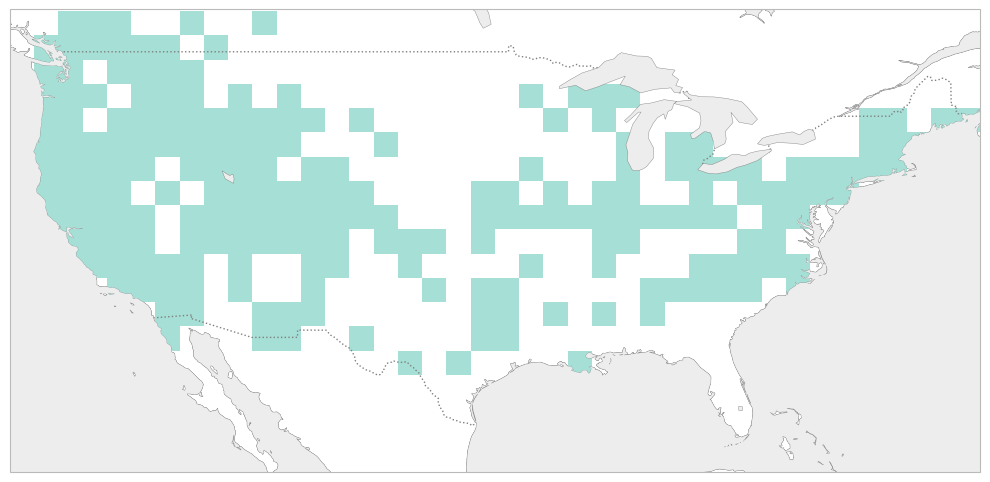

In [ ]:
gdf_to_plot = lig_2003
gdf_grid = create_grid(bounds, 1.5)

gdf_joined = gpd.sjoin(gdf_grid, gdf_to_plot, how="inner", op="intersects")
unique_grid_cells = gdf_joined.drop_duplicates(subset="index_right")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#a5dfd5', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/lig_2003.png', format='png', bbox_inches='tight', pad_inches=0)


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


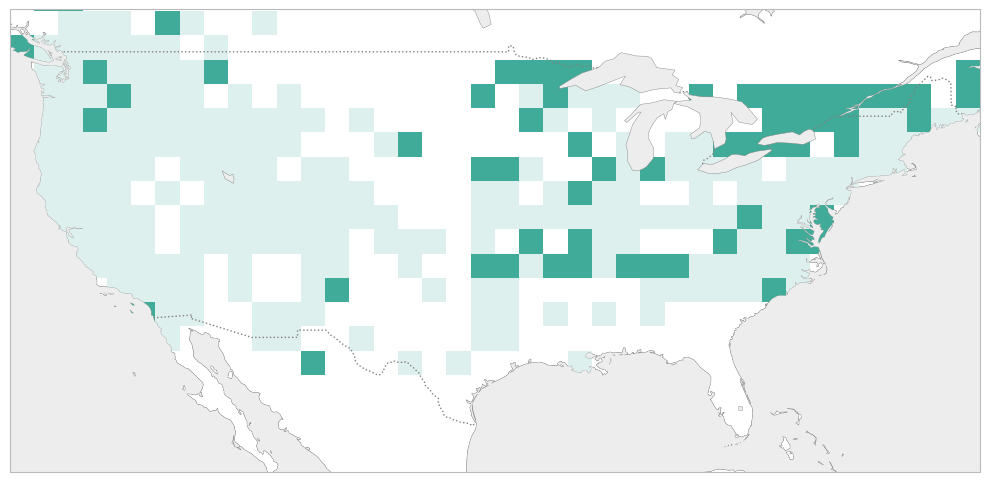

In [ ]:

joined_2003 = gpd.sjoin(gdf_grid, lig_2003, how="inner", op="intersects")
joined_2023 = gpd.sjoin(gdf_grid, lig_2023, how="inner", op="intersects")

unique_grid_cells = joined_2023[~joined_2023.index.isin(joined_2003.index.drop_duplicates())]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(joined_2003.geometry, crs=ccrs.PlateCarree(), facecolor='#ddf0ed', edgecolor=None , alpha=1)
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#41ab99', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/lig_2023.png', format='png', bbox_inches='tight', pad_inches=0)

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


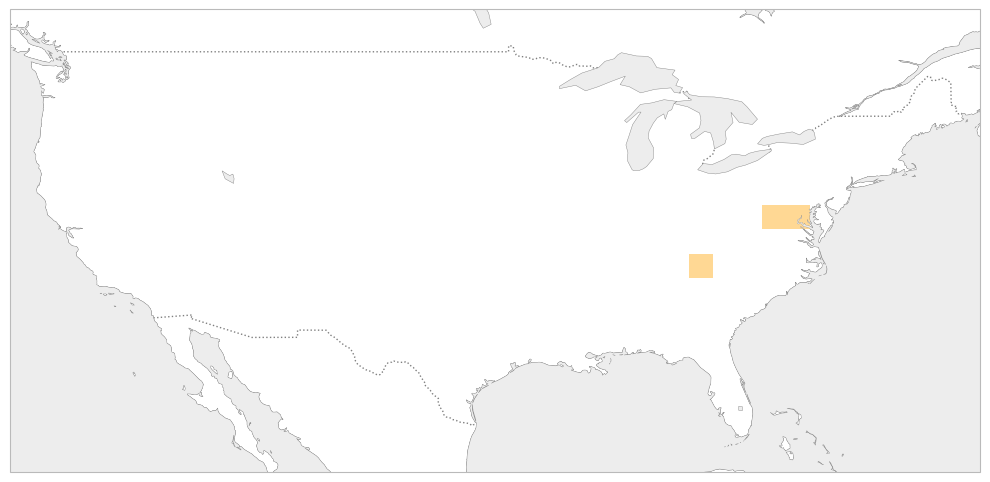

In [ ]:
gdf_to_plot = tau_2003
gdf_grid = create_grid(bounds, 1.5)

gdf_joined = gpd.sjoin(gdf_grid, gdf_to_plot, how="inner", op="intersects")
unique_grid_cells = gdf_joined.drop_duplicates(subset="index_right")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#ffd894', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/tau_2003.png', format='png', bbox_inches='tight', pad_inches=0)

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


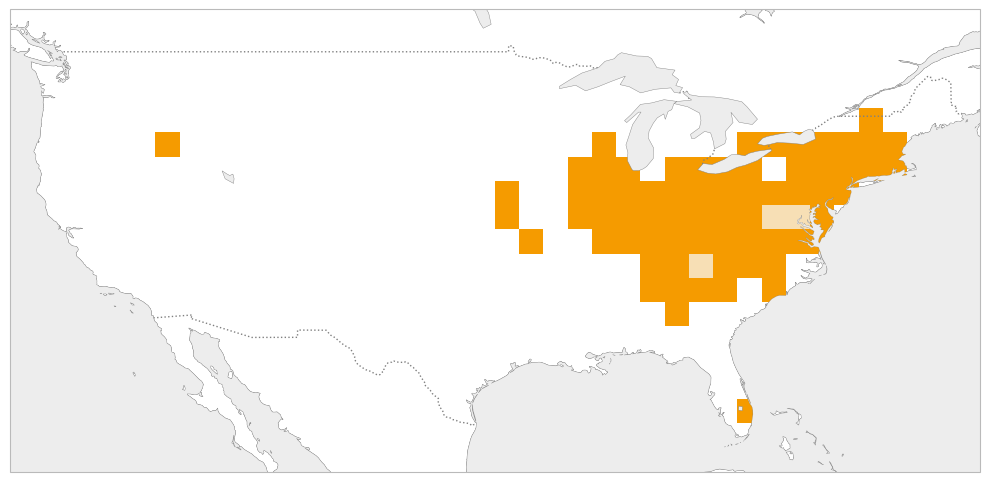

In [ ]:
joined_2003 = gpd.sjoin(gdf_grid, tau_2003, how="inner", op="intersects")
joined_2023 = gpd.sjoin(gdf_grid, tau_2023, how="inner", op="intersects")

unique_grid_cells = joined_2023[~joined_2023.index.isin(joined_2003.index.drop_duplicates())]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(joined_2003.geometry, crs=ccrs.PlateCarree(), facecolor='#f7dfb5', edgecolor=None , alpha=1)
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#f59b00', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/tau_2023.png', format='png', bbox_inches='tight', pad_inches=0)

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


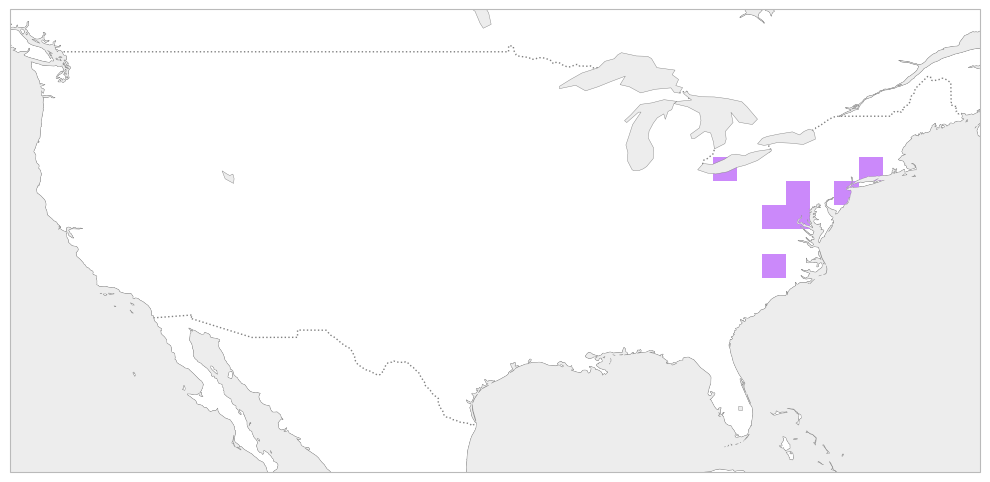

In [ ]:
gdf_to_plot = cfs_2003
gdf_grid = create_grid(bounds, 1.5)

gdf_joined = gpd.sjoin(gdf_grid, gdf_to_plot, how="inner", op="intersects")
unique_grid_cells = gdf_joined.drop_duplicates(subset="index_right")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#cb89fa', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/cfs_2003.png', format='png', bbox_inches='tight', pad_inches=0)

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


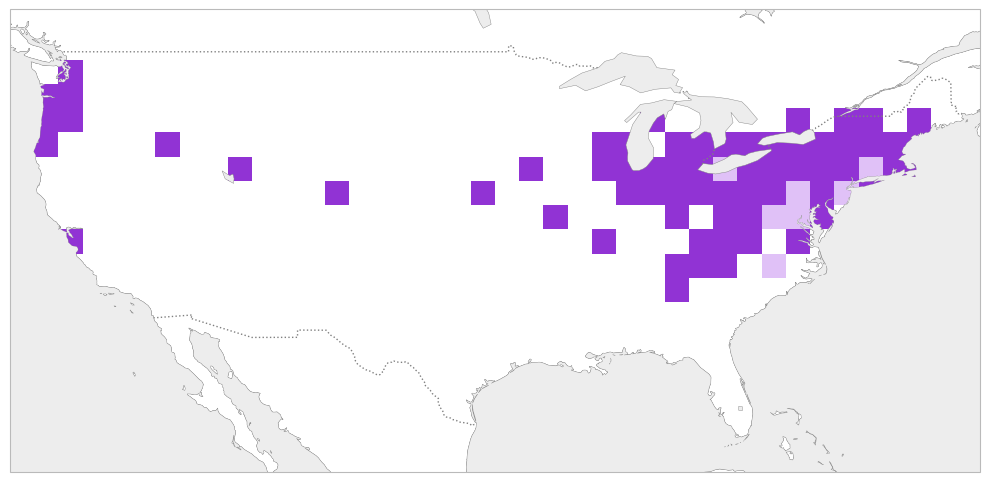

In [ ]:
joined_2003 = gpd.sjoin(gdf_grid, cfs_2003, how="inner", op="intersects")
joined_2023 = gpd.sjoin(gdf_grid, cfs_2023, how="inner", op="intersects")

unique_grid_cells = joined_2023[~joined_2023.index.isin(joined_2003.index.drop_duplicates())]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-126, -66, 23, 48])
ax.add_geometries(joined_2003.geometry, crs=ccrs.PlateCarree(), facecolor='#e0c1f7', edgecolor=None , alpha=1)
ax.add_geometries(unique_grid_cells.geometry, crs=ccrs.PlateCarree(), facecolor='#9133d4', edgecolor=None , alpha=1)

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=2, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('#bababa')
plt.tight_layout()
plt.savefig('../figures/dist/cfs_2023.png', format='png', bbox_inches='tight', pad_inches=0)

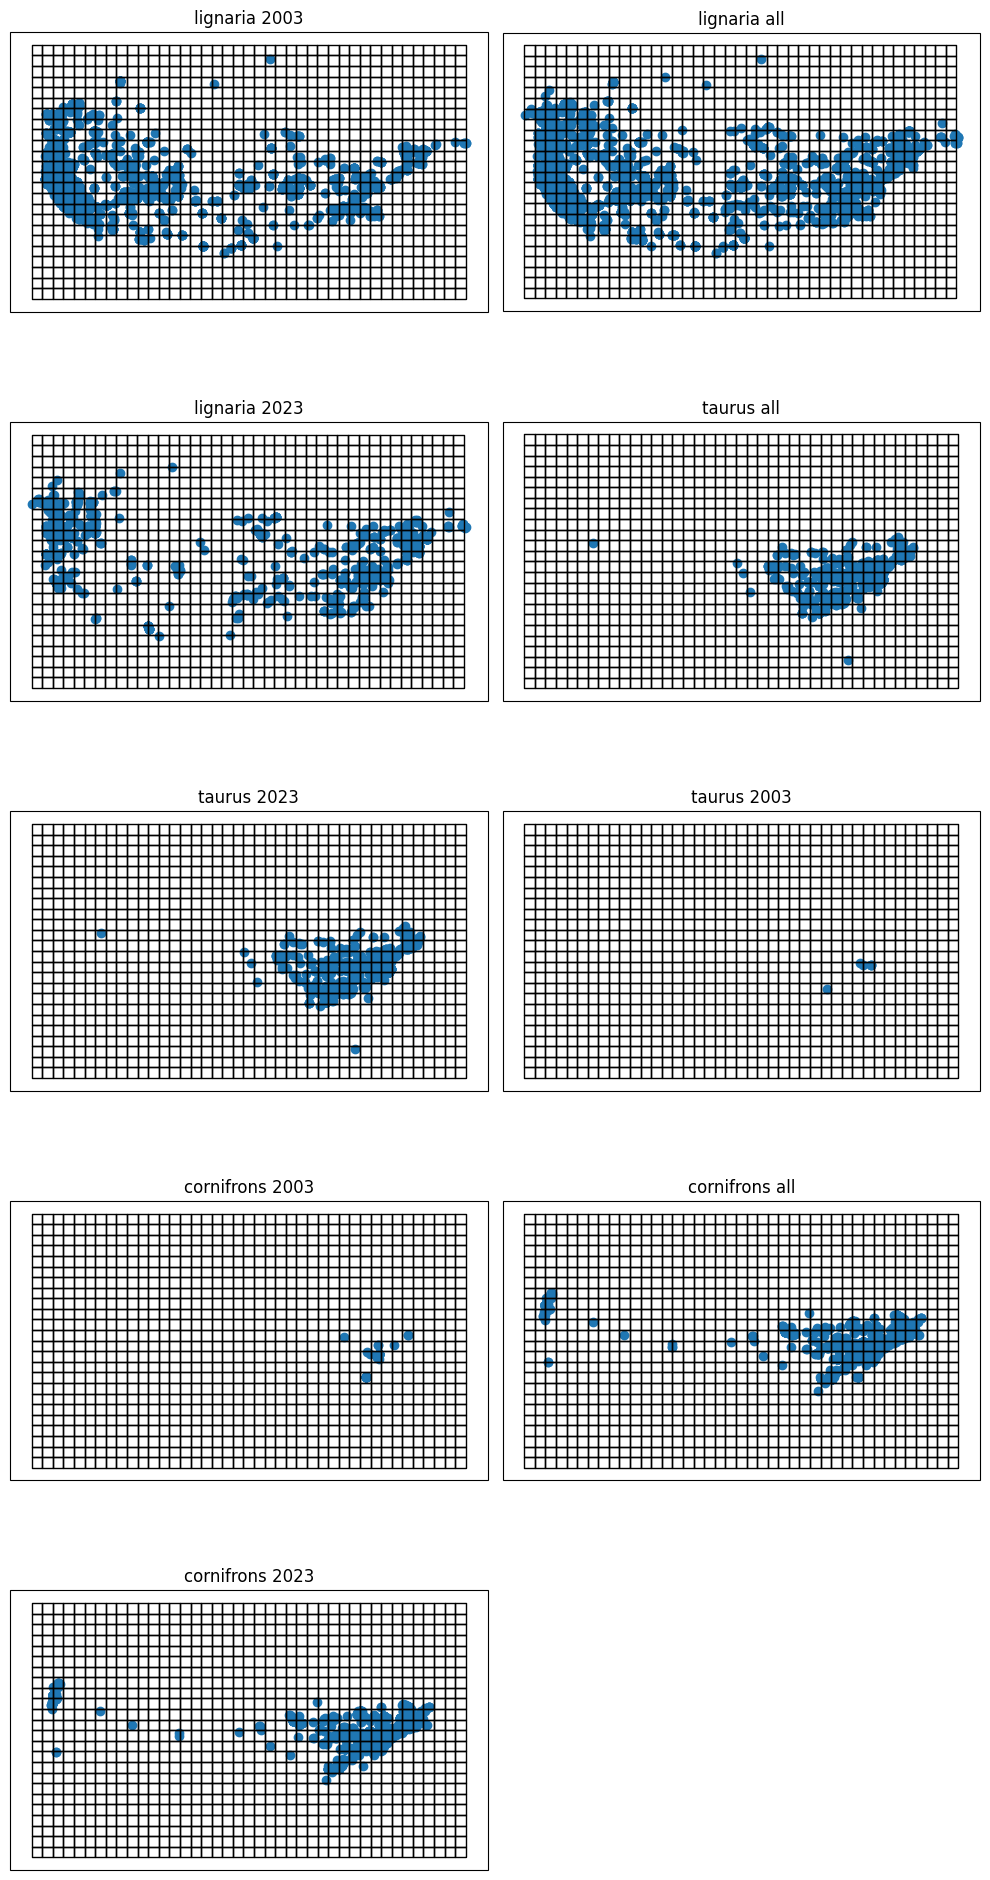

In [ ]:
num_dfs = len(dfs)*3
cols = 2 
rows = num_dfs // cols + (num_dfs % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 4), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

plot_idx = 0
for species, years_dict in dfs.items():
    for year, gdf in years_dict.items():
        gdf = create_geodf(gdf)

        gdf.plot(ax=axs[plot_idx])
        gdf_grid.plot(ax=axs[plot_idx], color='none', edgecolor='black')
        axs[plot_idx].set_title(f"{species} {year}")
        plot_idx += 1
        ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
        
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
        ax.set_extent([-126, -66, 23, 48])

        #hb = ax.hexbin(data['long'], data['lat'], gridsize=70, mincnt=1, cmap=cmap_lignaria, alpha=1, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
        ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')

        
        # ax.add_feature(great_lakes, facecolor='white', linewidth=.5, edgecolor='gray')

# If there are any remaining empty subplots, turn them off
for j in range(plot_idx, len(axs)):
    axs[j].axis('off')

plt.tight_layout() 

NameError: name 'tau_2003' is not defined

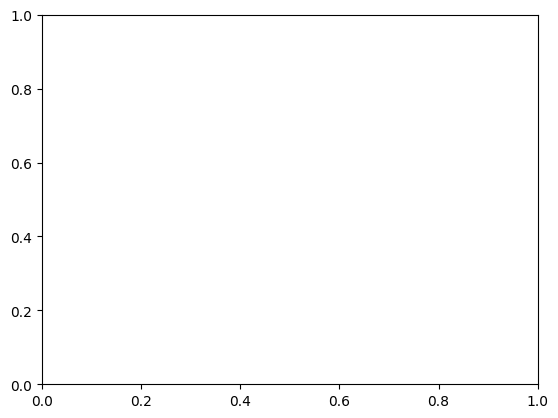

In [ ]:



fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', markersize=5)
gdf_grid.plot(ax=ax, color='none', edgecolor='black')
plt.show()

In [ ]:
lig_2003

,lat,long,geometry
0,39.012572,-77.287286,POINT (-77.287 39.013)
1,42.296638,-71.111824,POINT (-71.112 42.297)
2,40.001796,-75.120530,POINT (-75.121 40.002)
3,41.912318,-72.987882,POINT (-72.988 41.912)
4,43.750893,-71.524589,POINT (-71.525 43.751)
...,...,...,...
5329,41.279541,-72.815099,POINT (-72.815 41.280)
5330,35.994033,-78.898619,POINT (-78.899 35.994)
5331,47.660426,-122.280332,POINT (-122.280 47.660)
5332,47.660426,-122.280332,POINT (-122.280 47.660)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

lignaria_hex = '#6bdbc9'
colors = [mcolors.to_rgba(lignaria_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_lignaria = mcolors.LinearSegmentedColormap.from_list('lignaria', colors)

cornifrons_hex = '#c376f9'
colors = [mcolors.to_rgba(cornifrons_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_cornifrons = mcolors.LinearSegmentedColormap.from_list('cornifrons', colors)

taurus_hex = '#ffbe4d'
colors = [mcolors.to_rgba(taurus_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_taurus = mcolors.LinearSegmentedColormap.from_list('taurus', colors)

# cornuta_hex = '#6bdbc9'
# colors = [mcolors.to_rgba(cornuta_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
# cmap_cornuta = mcolors.LinearSegmentedColormap.from_list('cornuta', colors)

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')



NameError: name 'cfeature' is not defined

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature
import math

def point_in_cell(lat, lon, lat_bounds, lon_bounds):
    return (lat_bounds[0] <= lat <= lat_bounds[1]) and (lon_bounds[0] <= lon <= lon_bounds[1])

def plot_grid_filled_with_points(data_list, colors, species, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66



    # Constants
    km_per_degree_latitude = 111  # Approximate value
    central_latitude = (lat_max + lat_min) / 2  # Central latitude for longitude calculation
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for 100 km
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    # Create the base map with cartopy
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Define the grid size
    lat_bins = np.arange(lat_min, lat_max, degree_change_latitude)
    lon_bins = np.arange(lon_min, lon_max, degree_change_longitude)


    occupied_cells = set()

    for idx, data in enumerate(data_list):
        lats, lons = data['lat'], data['long']
        for i in range(len(lat_bins) - 1):
            for j in range(len(lon_bins) - 1):
                lat_bounds = (lat_bins[i], lat_bins[i+1])
                lon_bounds = (lon_bins[j], lon_bins[j+1])
                points_inside = [point for point in zip(lats, lons) if point_in_cell(point[0], point[1], lat_bounds, lon_bounds)]
                if points_inside:
                    # Add the occupied cell to the set
                    occupied_cells.add((i, j))

                    # Fill the cell on the map
                    ax.fill(
                        [lon_bounds[0], lon_bounds[1], lon_bounds[1], lon_bounds[0]],
                        [lat_bounds[0], lat_bounds[0], lat_bounds[1], lat_bounds[1]],
                        color=colors[idx]
                    )

    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
    ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')

    ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')

    # ax.set_title(f'{species}', x=0.1 , y=-0, color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('#bababa')
    
    # labels = ['2004-2023', 'pre-2003']
    # legend_patches = [
    #         mpatches.Patch(color=colors[1], label=labels[1]),  # 'other_species'
    #         mpatches.Patch(color=colors[0], label=labels[0])   # 'lignaria'
    #     ]
    #legend = ax.legend(handles=legend_patches, loc='lower right', borderaxespad=0.)
    # for patch in legend.get_patches():
    #     patch.set_height(10)  
    #     patch.set_width(10)   
    # legend = ax.legend(handles=legend_patches, 
    #     loc=(0.8, 0.17),   
    #     frameon=False,     
    #     handlelength=.8,    
    #     handletextpad=0.5, # Space between patch and text
    #     borderpad=0.5)     # Padding between border and contents (if frameon were True)
    # for text in legend.get_texts():
    #     text.set_color('gray')

    plt.tight_layout()

    aoo = len(occupied_cells) * (grid_size ** 2)
    return aoo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import math

def point_in_cell(lat, lon, lat_bounds, lon_bounds):
    return (lat_bounds[0] <= lat <= lat_bounds[1]) and (lon_bounds[0] <= lon <= lon_bounds[1])

def calculate_aoo(data_frame, lat_bins, lon_bins, grid_size):
    occupied_cells = set()
    for index, row in data_frame.iterrows():
        lat, lon = row['lat'], row['long']
        for i in range(len(lat_bins) - 1):
            for j in range(len(lon_bins) - 1):
                lat_bounds = (lat_bins[i], lat_bins[i + 1])
                lon_bounds = (lon_bins[j], lon_bins[j + 1])
                if point_in_cell(lat, lon, lat_bounds, lon_bounds):
                    occupied_cells.add((i, j))
    return len(occupied_cells) * (grid_size ** 2)


def calculate_aoo_with_shift(data_list, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66

    # Constants for degree change calculation
    km_per_degree_latitude = 111  # Approximate value
    central_latitude = (lat_max + lat_min) / 2  # Central latitude for longitude calculation
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for grid size
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    # Original grid bins
    original_lat_bins = np.arange(lat_min, lat_max, degree_change_latitude)
    original_lon_bins = np.arange(lon_min, lon_max, degree_change_longitude)

    # Calculate original AOO
    aoo_original = calculate_aoo(data_list, original_lat_bins, original_lon_bins, grid_size)

    # Calculate AOO for shifted grids
    shifts = [(0, 0), (0.01, 0), (-0.01, 0), (0, 0.01), (0, -0.01)]  # Example shifts in degrees
    aoo_values = []
    for shift in shifts:
        shifted_lat_bins = np.arange(lat_min + shift[0], lat_max + shift[0], degree_change_latitude)
        shifted_lon_bins = np.arange(lon_min + shift[1], lon_max + shift[1], degree_change_longitude)
        aoo_shifted = calculate_aoo(data_list, shifted_lat_bins, shifted_lon_bins, grid_size)
        aoo_values.append(aoo_shifted)

    # Estimate error
    aoo_error = np.std(aoo_values)

    # Plotting code (omitted for brevity)

    return aoo_original, aoo_error


In [ ]:
# aoo_2003, error_2003 = calculate_aoo_with_shift(locs_2003['cornifrons'])
# aoo_2023, error_2023 = calculate_aoo_with_shift(locs_2004['cornifrons'])

In [ ]:
# aoo_2003_lig, error_2003_lig = calculate_aoo_with_shift(locs_2003['lignaria'])
# aoo_2023_lig, error_2023_lig = calculate_aoo_with_shift(locs_2004['lignaria'])
# aoo_2003_crta, error_2003_crta = calculate_aoo_with_shift(locs_2003['taurus'])
# aoo_2023_crta, error_2023_crta = calculate_aoo_with_shift(locs_2004['taurus'])

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


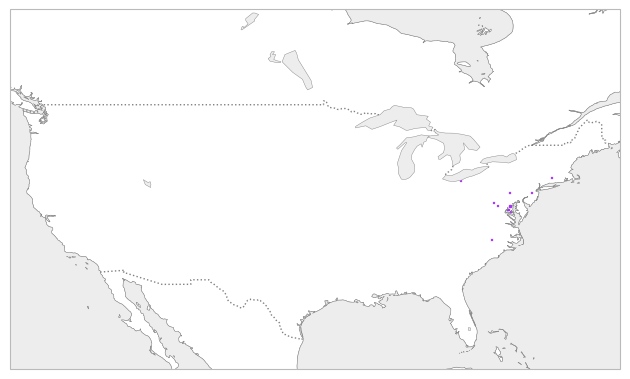

In [ ]:
colors = ['#a431f6', '#cb89fa']
data_list = [locs_2003['cornifrons']]
aoo_2003 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons')
#plt.savefig('figures/dist/cornifrons_dist_swapped.png', format='png', bbox_inches='tight', pad_inches=0)

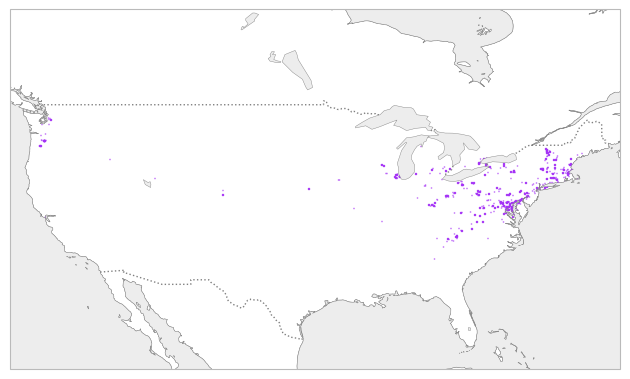

In [ ]:
colors = ['#a431f6', '#cb89fa']
data_list = [locs_2004['cornifrons']]
aoo_2004_50 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=5)
#plt.savefig('figures/dist/cornifrons_dist_swapped.png', format='png', bbox_inches='tight', pad_inches=0)

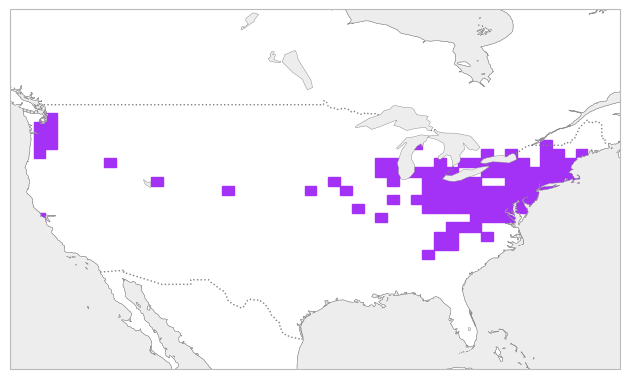

In [ ]:
aoo_2004_100 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=100)

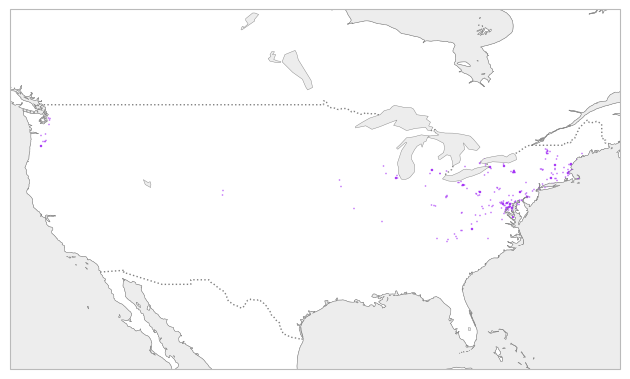

In [ ]:
aoo_2004_2 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=2)

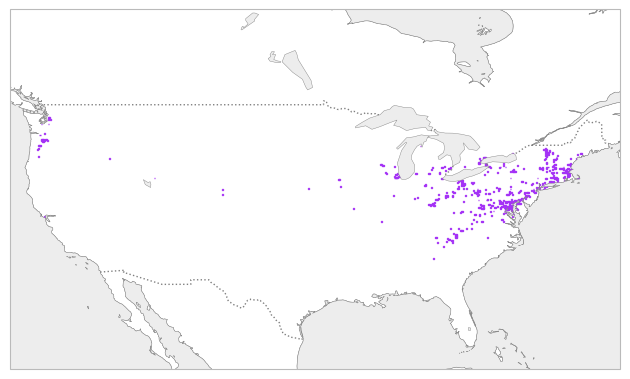

In [ ]:
aoo_2004_10 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=10)

In [ ]:
print(aoo_2004_10, aoo_2004_2, aoo_2004_100, aoo_2004_50)

47700 2580 1100000 505000


In [ ]:
# time_points = ['2003', '2023']
# aoos = [aoo_2003_crta, aoo_2023_crta]
# errors = [error_2003_crta, error_2023_crta]

# plt.figure(figsize=(2, 4))
# plt.bar(time_points, aoos)
# plt.errorbar(time_points, aoos, yerr=errors, fmt='.', color='black', capsize=10)

# plt.xlabel('Year')
# plt.ylabel('Area of Occupancy (km²)')
# plt.title('AOO Over Time')


In [ ]:
# time_points = ['2003', '2023']
# aoos = [aoo_2003, aoo_2004]
# errors = [error_2003, error_2023]

# plt.figure(figsize=(2, 4))
# plt.bar(time_points, aoos)
# plt.errorbar(time_points, aoos, yerr=errors, fmt='.', color='black', capsize=10)

# plt.xlabel('Year')
# plt.ylabel('Area of Occupancy (km²)')
# plt.title('AOO Over Time')


In [ ]:
import multiprocessing

def calculate_aoo_wrapper(shift, data_list, lat_min, lat_max, lon_min, lon_max, grid_size):
    # Constants for degree change calculation
    km_per_degree_latitude = 111
    central_latitude = (lat_max + lat_min) / 2
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for grid size
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    shifted_lat_bins = np.arange(lat_min + shift[0], lat_max + shift[0], degree_change_latitude)
    shifted_lon_bins = np.arange(lon_min + shift[1], lon_max + shift[1], degree_change_longitude)

    return calculate_aoo(data_list, shifted_lat_bins, shifted_lon_bins, grid_size)

def calculate_aoo_with_shift_parallel(data_list, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66

    # Define shifts
    shifts = [(0, 0), (0.05, 0), (-0.05, 0), (0, 0.05), (0, -0.05)]

    # Create a pool of worker processes
    with multiprocessing.Pool() as pool:
        # Prepare arguments for the wrapper function
        args = [(shift, data_list, lat_min, lat_max, lon_min, lon_max, grid_size) for shift in shifts]

        # Perform parallel processing
        aoo_values = pool.starmap(calculate_aoo_wrapper, args)

    # Calculate original and error
    aoo_original = aoo_values[0]  # Assuming the first shift is (0, 0)
    aoo_error = np.std(aoo_values)

    return aoo_original, aoo_error


In [ ]:
orig, err = calculate_aoo_with_shift_parallel(locs_2003['lignaria'])

In [ ]:
lig_concat = pd.concat([locs_2003['lignaria'], locs_2004['lignaria']], ignore_index=True)

aoo_2003_cfns, error_2003_cfns = calculate_aoo_with_shift_parallel(locs_2003['cornifrons'])
aoo_2023_cfns, error_2023_cfns = calculate_aoo_with_shift_parallel(locs_2004['cornifrons'])
aoo_2003_lig, error_2003_lig = calculate_aoo_with_shift_parallel(locs_2003['lignaria'])
aoo_2023_lig, error_2023_lig = calculate_aoo_with_shift_parallel(lig_concat)
aoo_2003_taur, error_2003_taur = calculate_aoo_with_shift_parallel(locs_2003['taurus'])
aoo_2023_taur, error_2023_taur = calculate_aoo_with_shift_parallel(locs_2004['taurus'])

In [ ]:
aoo_list = [aoo_2003_cfns,
aoo_2023_cfns,
aoo_2003_lig,
aoo_2023_lig,
aoo_2003_taur,
aoo_2023_taur]
error_list = [error_2003_cfns,
error_2023_cfns,
error_2003_lig,
error_2023_lig,
error_2003_taur,
error_2023_taur]



In [ ]:
# import json

# data = {
#     "aoo_list": aoo_list,
#     "error_list": error_list
# }

# with open('aoo_data.json', 'w') as file:
#     json.dump(data, file, indent=4)

In [ ]:
import json
import os

In [ ]:
aoo_data = {}

for json_file in os.listdir('output/'):
    name = json_file[:-5].split('_')[2]+'_'+json_file[:-5].split('_')[3]
    with open(os.path.join('output/',json_file), 'r') as file:
        data = json.load(file)
        aoo_data[name] = {'mean_aoo':data['mean_aoo'],
                          'error':data['std_aoo']}
print(aoo_data)


{'lignaria_2003': {'mean_aoo': 76906.4, 'error': 1064.5933683806227}, 'taurus_all': {'mean_aoo': 32522.8, 'error': 626.4823700631965}, 'cornifrons_all': {'mean_aoo': 37393.6, 'error': 580.1715608335176}, 'cornifrons_2023': {'mean_aoo': 35846.4, 'error': 830.5703100881949}, 'taurus_2023': {'mean_aoo': 32460.6, 'error': 882.9652541295156}, 'lignaria_2023': {'mean_aoo': 42605.2, 'error': 973.8444228931024}, 'taurus_2003': {'mean_aoo': 249.4, 'error': 99.69774320414679}, 'cornifrons_2003': {'mean_aoo': 1114.0, 'error': 140.29967925836468}, 'lignaria_all': {'mean_aoo': 123745.6, 'error': 1403.5101139642704}}


/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])


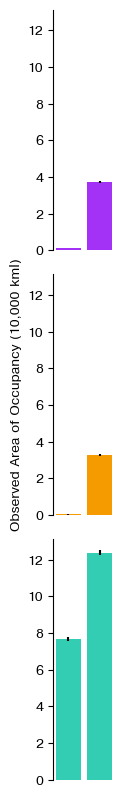

In [ ]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_data['cornifrons_2003']['mean_aoo'], aoo_data['cornifrons_all']['mean_aoo']], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_data['cornifrons_2003']['mean_aoo'], aoo_data['cornifrons_all']['mean_aoo']], yerr=[aoo_data['cornifrons_2003']['error'], aoo_data['cornifrons_all']['error']], fmt='none', color='black', capsize=0)


axs[1].bar(time_points, [aoo_data['taurus_2003']['mean_aoo'], aoo_data['taurus_all']['mean_aoo']], color='#f59b00')
axs[1].errorbar(time_points, [aoo_data['taurus_2003']['mean_aoo'], aoo_data['taurus_all']['mean_aoo']], yerr=[aoo_data['taurus_2003']['error'], aoo_data['taurus_all']['error']], fmt='none', color='black', capsize=0)  
axs[1].set_ylabel('Observed Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_data['lignaria_2003']['mean_aoo'], aoo_data['lignaria_all']['mean_aoo']], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_data['lignaria_2003']['mean_aoo'], aoo_data['lignaria_all']['mean_aoo']], yerr=[aoo_data['lignaria_2003']['error'], aoo_data['lignaria_all']['error']], fmt='none', color='black', capsize=0)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    #ax.set_ylim(16)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels([], rotation=45)  # Rotate by 45 degrees

# # Adjust the layout
# plt.tight_layout()
plt.savefig('../figures/aoo_barplot.svg', format='svg')

In [ ]:


# with open('aoo_data.json', 'r') as file:
#     data = json.load(file)

# # Extract the lists from the data
# aoo_list = data["aoo_list"]
# error_list = data["error_list"]

# aoo_var_names = [
#     'aoo_2003_cfns', 'aoo_2023_cfns', 'aoo_2003_lig', 
#     'aoo_2023_lig', 'aoo_2003_taur', 'aoo_2023_taur'
# ]

# error_var_names = [
#     'error_2003_cfns', 'error_2023_cfns', 'error_2003_lig', 
#     'error_2023_lig', 'error_2003_taur', 'error_2023_taur'
# ]


# for var_name, value in zip(aoo_var_names, aoo_list):
#     globals()[var_name] = value

# for var_name, value in zip(error_var_names, error_list):
#     globals()[var_name] = value

/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])


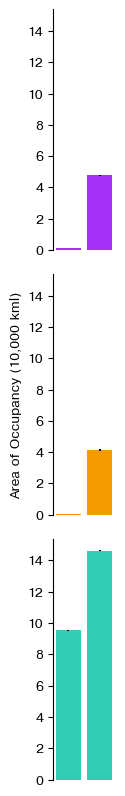

In [ ]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_2003_cfns, aoo_2023_cfns], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_2003_cfns, aoo_2023_cfns], yerr=[error_2003_cfns, error_2023_cfns], fmt='none', color='black', capsize=0)


axs[1].bar(time_points, [aoo_2003_taur, aoo_2023_taur], color='#f59b00')
axs[1].errorbar(time_points, [aoo_2003_taur, aoo_2023_taur], yerr=[error_2003_taur, error_2023_taur], fmt='none', color='black', capsize=0)  
axs[1].set_ylabel('Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_2003_lig, aoo_2023_lig], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_2003_lig, aoo_2023_lig], yerr=[error_2003_lig, error_2023_lig], fmt='none', color='black', capsize=0)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    #ax.set_ylim(16)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels([], rotation=45)  # Rotate by 45 degrees

# # Adjust the layout
# plt.tight_layout()
# plt.savefig('figures/dist/aoo_plot.svg', format='svg')



In [ ]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_2003_cfns, aoo_2023_cfns], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_2003_cfns, aoo_2023_cfns], yerr=[error_2003_cfns, error_2023_cfns], fmt='none', color='black', capsize=6)

axs[1].bar(time_points, [aoo_2003_taur, aoo_2023_taur], color='#f59b00')
axs[1].errorbar(time_points, [aoo_2003_taur, aoo_2023_taur], yerr=[error_2003_taur, error_2023_taur], fmt='none', color='black', capsize=6)  
axs[1].set_ylabel('Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_2003_lig, aoo_2023_lig], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_2003_lig, aoo_2023_lig], yerr=[error_2003_lig, error_2023_lig], fmt='none', color='black', capsize=6)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels(time_points, rotation=45)  # Rotate by 45 degrees


In [ ]:
file1 = '/home/mpgetz/repos/bee_mapping/calculate_aoo/df2csv/lignaria_2003.csv'
file2 = '/home/mpgetz/repos/bee_mapping/calculate_aoo/df2csv/lignaria_2023.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2])

# Export the combined DataFrame to a new CSV file
output_file = 'lignaria_combined.csv'
combined_df.to_csv(output_file, index=False)

,lat,long
0,47.618215,-122.302601
1,42.260889,-70.870778
2,42.260889,-70.870778
3,42.287861,-70.946167
4,42.281694,-70.900167
...,...,...
1525,52.646900,-122.424000
1526,31.321000,-109.256000
1527,33.093828,-96.641450
1528,47.761584,-122.305169
